In [3]:

import numpy as np 
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"/openmd")

from SimulatorLJ import SimulatorLJ as Simulator

def initialize(num_part, sigma, length):
    """
    :param num_part:
    :type num_part:
    :return:
    :rtype:
    """
    coordinates = np.zeros((num_part, 3))
    pos_x = (0, length, 2**(1/6)*sigma)
    i = 0
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                coordinates[i, :] = np.array([x , y ,z])
                i += 1
                if i == num_part-1:
                    break
            if i == num_part - 1:
                break
        if i == num_part - 1:
            break
    return coordinates

coordinates = initialize(64, 1, 6)
velocities = np.zeros((64,3))
sim = Simulator(
    mass = 1,
    sim_time= 100,
    time_step = 1,
    initial_values = [coordinates,velocities],
    box_length = 6 ,
    force=None,
    force_constants=[1, 1],
    integrator=None,
    periodic=True,
)
positions, velocities = sim.simulate()

/home/julian/Documents/openmd/openmd


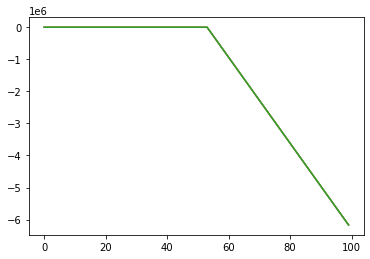

In [7]:
import matplotlib.pyplot as plt 
plt.plot(positions[0,:,:].T)